In [1]:
from compChem.Hartree_Fock import Molecule # package is available on github
from scipy.linalg import eigh, eig
import numpy as np
import psi4

In [2]:
numpy_memory = 4
psi4.set_memory(int(5e8))

500000000

In [3]:
class ConstrainedMolecule:
    def __init__(self, geom_file, radical=False):
        """initiation method, will take in a geometry"""
        #this parameter contains all parameters and methods from the Molecule class
        self.id = Molecule(geom_file)
        self.id.setGuess()
        
    
    def setChargeDensity(self, new_matrix):
        """sets the pMatrix to a new value"""
        self.pMatrix = new_matrix
        
    
    def basischanger(self):
        """
        changes to NO basis, applies constraint, then changes back
        """
        # transform p to MO basis, where mo basis = the eigenfunctions of the f_a operator
        a = self.id.getDensityMatrix("alpha")
        b = self.id.getDensityMatrix("beta")
        f_a, f_b = self.id.displayFockMatrix("alpha"), self.id.displayFockMatrix("beta")
        p = (a+b)/2
        c = eigh(f_a, self.id.overlap)[1] # we only need the c matrix, not the eigenvalues themselves,
        
        delta = (f_b-f_a)/2
        f_cs = (f_a+f_b)/2
        # pay attention, c matrices are not unitary
        c_inv = np.linalg.inv(c) # we need the inverse for later
        p_trans = np.einsum("pq, qr, rs->ps", c_inv, p, c_inv.T, optimize=True)
        delta_trans = np.einsum("pq, qr, rs->ps", c.T, delta, c, optimize=True)
        
        
         # transform the fock matrices to NO basis
        d = eigh(p_trans)[1]
        d = d[:, ::-1] #invert all collumns
    
        d_inv = np.linalg.inv(d)
        delta_no = np.einsum("pq, qr, rs->ps", d.T, delta_trans, d, optimize=True)
        
        alpha = self.id.alpha 
        beta = self.id.beta
        #alter first blocks
        
        delta_no[alpha:, :beta] = 0
        delta_no[:beta, alpha:] = 0
        delta_ao = np.einsum("pq, qr, rs->ps",c_inv.T.dot(d_inv.T), delta_no, d_inv.dot(c_inv), optimize=True)
        
        
        return f_cs - delta_ao, f_cs + delta_ao
    
    
    def iteratinator(self):
        """adapted version of the original iterator function in the compChem.Hartree_Fock Molecule object"""
        # setting up entry parameters for the while loop
        E_new = 0  
        E_old = 0
        convergence = False

        # step 2: start iterating
        itercount = 0
        while not convergence and itercount < 5000:
            # calculating block: calculates energies
            E_new = self.id.getElectronicEnergy()
            E_total = self.id.getTotalEnergy()

            # generating block: generates new matrices UHF: account for alpha and beta, first we do the CUHF alteration
            f_a_n, f_b_n = self.basischanger()
            self.id.setGuess(f_a_n, "alpha")
            self.id.setGuess(f_b_n, "beta")

            # comparing block: will answer the "Are we there yet?" question
            if abs(E_old - E_new) < self.id.converge:
                convergence = True


            # maintenance block: keeps everything going
            #print(f"iteration: {itercount}, E_tot: {E_total: .8f}, E_elek: {E_new: .8f}, deltaE: {E_new - E_old: .8f}")
            E_old = E_new

            itercount += 1
        
        return E_total
    
    def setElectrons(self, alpha, beta):
        """sets the amount electrons of each spin"""
        self.id.alpha = alpha
        self.id.beta = beta

In [81]:
psi4.set_options({"BASIS": "cc-pvdz", 'reference': 'cuhf'})
h1 = ConstrainedMolecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""")
h1.id.setConvergence(1e-20)
h1.iteratinator()

-1.5031118631777232

In [ ]:
h3 = Molecule

In [84]:
psi4.set_options({"basis":"STO-3G", 'reference':'cuhf'})
allyl = ConstrainedMolecule("""
0 2
H
C 1 r2
C 2 r3 1 a3
C 2 r3 1 a3 3 180.
H 3 r5 2 a5 1 0.
H 4 r5 2 a5 1 0.
H 3 r7 2 a7 1 180.
H 4 r7 2 a7 1 180.

r2=1.08424658
r3=1.40526604
r5=1.08095381
r7=1.08131649
a3=117.99450641
a5=121.41544408
a7=121.21891262
symmetry c1

""")
allyl.id.setConvergence(1e-12)
a = allyl.id.alpha
b = allyl.id.beta
tot = a + b -1

allyl.setElectrons(a,b) 
allyl.iteratinator()

-115.0106431221825

In [12]:
psi4.energy("scf")

-115.00929345804687

In [7]:
psi4.set_options({"basis":"cc-pvdz",'reference':'cuhf'})
m2 = ConstrainedMolecule("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")
m2.id.setConvergence(1e-20)
m2.iteratinator()

-76.02665366188843

In [8]:
mol = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")
psi4.energy('scf')

-76.02663273455212

In [14]:
m3 = ConstrainedMolecule("""pubchem:methane""")
m3.iteratinator()

	Searching PubChem database for methane (single best match returned)
	Found 1 result(s)


-39.72658174267161

In [15]:
psi4.energy("scf")

-39.7267287296455

In [37]:
psi4.set_options({'basis': "cc-pvdz"})
distances = np.arange(0.2, 10, 0.1)
atom = ConstrainedMolecule("""
H
""")
E_elek_list = []
E_total_list = []
loglist = []

E_H = atom.iteratinator()
for distance in distances:
    hydrogen = ConstrainedMolecule(
    f"""
    H 0 0 0
    H {distance} 0 0
    
    """)
    
    E_total = hydrogen.iteratinator()
    E = E_total - 2*E_H
    logE = np.log(abs(E))
    E_total_list.append(E_total - 2*E_H)
    loglist.append(logE)

/user/gent/440/vsc44013/.local/lib/python3.7/site-packages/compChem/Hartree_Fock.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.guessMatrix_a == "empty" and self.guessMatrix_b == "empty":


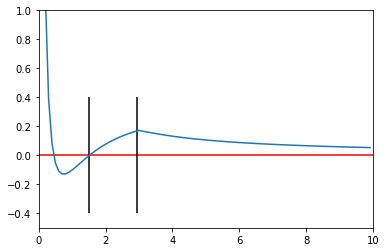

In [66]:
import matplotlib.pyplot as plt
plt.plot(distances, E_total_list)
plt.hlines(0, 0, 10, color="red")
plt.axis([0, 10, -0.5, 1])
plt.vlines(1.4925, -0.4, 0.4, color="black")
plt.vlines(2.9412, -0.4, 0.4, color="black")

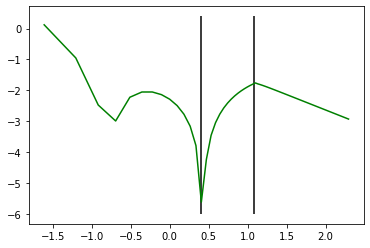

In [70]:
plt.plot(np.log(distances), loglist, color='green')
plt.vlines(np.log(2.9412), -6, 0.4, color="black")
plt.vlines(np.log(1.4925), -6, 0.4, color="black")

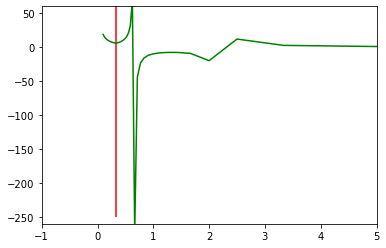

In [65]:
E_array = np.array(E_total_list)
plt.plot((distances)**-1, E_array**-1, color='green')
plt.axis([-1, 5, -260, 60])
plt.vlines(0.34, -250, 69, color="red")

In [35]:
atom = ConstrainedMolecule("""
H
""")
atom.iteratinator()

/user/gent/440/vsc44013/.local/lib/python3.7/site-packages/compChem/Hartree_Fock.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.guessMatrix_a == "empty" and self.guessMatrix_b == "empty":


-0.4992784034195832

In [36]:
psi4.energy("scf")

-0.49927840341958285

This value does not seem correct (UHF gives about -1.506 H for the total energy). This might be the case because the Fock operator depends on the two electron integrals have not been transformed to the correct basis yet. Can this be the case?


In [ ]:
psi4.set_options({"BASIS": "cc-pvdz"})
h_test = ConstrainedMolecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""")

In [ ]:
s = h_test.id.overlap
s_eigh = eigh(s)
s_diag = np.diag(s_eigh[0]**(-1/2))
x = s_eigh[1].dot(s_diag).dot(s_eigh[1].T)
x.T.dot(s).dot(x)

In [ ]:
a = h_test.id.getDensityMatrix('alpha')
b = h_test.id.getDensityMatrix('beta')
x_i = np.linalg.inv(x)
x_i_t = np.linalg.inv(x.T)
a_trans = x_i.dot(a).dot(x_i_t)
b_trans = x_i.dot(b).dot(x_i_t)
p = (a_trans + b_trans)/2
c = eigh(p)
c

Up untill here everything should be correct (density matrices are idempotent, p matrix has correct eigenvalues). The area below is still under construction.

In [ ]:
f_a = h_test.id.displayFockMatrix('alpha')
f_b = h_test.id.displayFockMatrix('beta')

In [ ]:
f_a_trans = x.dot(f_a).dot(x.T)
f_a_no = c[1].T.dot(f_a_trans).dot(c[1])
f_b_trans = x.dot(f_b).dot(x.T)
f_b_no = c[1].T.dot(f_b_trans).dot(c[1])

This expression seems a bit too simple. Nevertheless, according to Tsuchimochi & Scuseria it should hold.

In [ ]:
f_cs = (f_a_no + f_b_no)/2

In [ ]:
a = h_test.id.getDensityMatrix("alpha")
b = h_test.id.getDensityMatrix("beta")
a - b

In [ ]:
f_b = h_test.id.displayFockMatrix("beta")
f_a = h_test.id.displayFockMatrix("alpha")

In [ ]:
f_cs = (f_a + f_b)/2

In [ ]:
a = h_test.id.getDensityMatrix("alpha")
b = h_test.id.getDensityMatrix("beta")
p = (a + b)/2

In [ ]:
c1, c = eigh(f_a, h_test.id.overlap)
c_inv = np.linalg.inv(c)
c_inv

In [ ]:
d = c_inv.T.dot(p).dot(c_inv)
o1, o = eigh(d)
o = o[:, ::-1]
j = o.T.dot(d).dot(o)
j[abs(j) < 1e-10] = 0
j

In [ ]:
f_trans = c.T.dot(f_a).dot(c)
f_trans[abs(f_trans) < 1e-10] = 0
f_trans

In [ ]:
a_trans = c_inv.dot(a).dot(c_inv.T)
a_no = o.T.dot(a_trans).dot(o)
a_no[abs(a_no) < 1e-10] = 0
a_no


In [ ]:
o.dot(a_no).dot(o.T)

In [ ]:
a_trans

In [ ]:
y = eigh(p, h_test.id.overlap)

In [ ]:
n = np.array([[1,2], [2,3]])
v = eigh(n)
v

In [ ]:
v[1].dot(n).dot(v[1].T)

In [ ]:
o.T.dot(o)

In [5]:
psi4.set_options({"BASIS": "cc-pvdz", 'reference': 'cuhf'})
h1 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""")
h1.setConvergence(1e-12)
h1.iterator(constraint=True)

  0.00000000, rmsD:  0.00000000
iteration: 224, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 225, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 226, E_tot: -1.50311186, E_elek: -3.09064350, deltaE:  0.00000000, rmsD:  0.00000000
iteration: 227, E_tot: -1.50311186, E_elek: -3.09064350, deltaE:  0.00000000, rmsD:  0.00000000
iteration: 228, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 229, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 230, E_tot: -1.50311186, E_elek: -3.09064350, deltaE:  0.00000000, rmsD:  0.00000000
iteration: 231, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 232, E_tot: -1.50311186, E_elek: -3.09064350, deltaE:  0.00000000, rmsD:  0.00000000
iteration: 233, E_tot: -1.50311186, E_elek: -3.09064350, deltaE: -0.00000000, rmsD:  0.00000000
iteratio

-1.5031118631777391